In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import F1Score

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

In [9]:
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10          
EPOCHS = 20              
BATCH_SIZE = 64 

In [10]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [11]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

In [12]:
y_train = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

In [13]:
print(f"X_train shape after preprocessing: {X_train.shape}")
print(f"y_train shape after preprocessing: {y_train.shape}")
print(f"X_test shape after preprocessing: {X_test.shape}")
print(f"y_test shape after preprocessing: {y_test.shape}")
print(f"Input shape to be used: {INPUT_SHAPE}, Number of classes: {NUM_CLASSES}\n")

X_train shape after preprocessing: (50000, 32, 32, 3)
y_train shape after preprocessing: (50000, 10)
X_test shape after preprocessing: (10000, 32, 32, 3)
y_test shape after preprocessing: (10000, 10)
Input shape to be used: (32, 32, 3), Number of classes: 10



In [ ]:
class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

def plot_history(history_object, title):
    history_data = history_object.history

    plt.figure(figsize=(12, 4))

    exps = sorted(history_data.keys(), key=lambda x: x)
        
    ax1 = plt.subplot(1,2,1)
    for e in exps:
        ax1.plot(history_data[e]['loss'], label=e.replace('_',' '), lw=2)
    ax1.set_title(f'Effect of {title} – Training Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(alpha=0.3)
    ax1.legend()
    
    ax2 = plt.subplot(1,2,2)
    for e in exps:
        ax2.plot(history_data[e]['val_loss'], linestyle='--', label=e.replace('_',' '), lw=2)
    ax2.set_title(f'Effect of {title} – Validation Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(alpha=0.3)
    ax2.legend()

def evaluate_model_f1(model, X_test_data, y_test_data_one_hot, model_name="Model"):
    print(f"\nEvaluating {model_name}...")
    loss, accuracy, f1_metric_value = model.evaluate(X_test_data, y_test_data_one_hot, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Macro F1-Score (from model.evaluate): {f1_metric_value:.4f}")

    y_pred_proba = model.predict(X_test_data)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_true_classes = np.argmax(y_test_data_one_hot, axis=1)
    
    sklearn_f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
    print(f"Test Macro F1-Score (calculated with scikit-learn): {sklearn_f1:.4f}")
    return sklearn_f1

f1_metric_compiler = F1Score(average='macro', name='f1_score_macro')
METRICS_TO_COMPILE = ['accuracy', f1_metric_compiler]

experiment_results = {}

In [15]:
def create_model_varied_conv_layers(num_conv_layers, input_shape, num_classes):
    model = models.Sequential(name=f"CNN_{num_conv_layers}_ConvLayers")
    model.add(layers.Input(shape=input_shape))

    filters = 32
    kernel_size = (3, 3)
    pool_size = (2, 2)
    
    current_height = input_shape[0]
    current_width = input_shape[1]

    for i in range(num_conv_layers):
        current_filters = filters * (2**(i // 2)) 
        model.add(layers.Conv2D(current_filters, kernel_size, activation='relu', padding='same', name=f"conv2d_layer_{i+1}"))
        
        if current_height >= pool_size[0] and current_width >= pool_size[1]:
            model.add(layers.MaxPooling2D(pool_size, name=f"maxpool_layer_{i+1}"))
            current_height //= pool_size[0]
            current_width //= pool_size[1]
        else:
            print(f"Skipping MaxPooling2D for conv_layer_{i+1} due to small dimensions: {current_height}x{current_width}")
        
    model.add(layers.Flatten(name="flatten_layer"))
    model.add(layers.Dense(128, activation='relu', name="dense_layer_1")) 
    model.add(layers.Dropout(0.5, name="dropout_layer"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output_layer"))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=METRICS_TO_COMPILE)
    return model

num_layers_variations = [2, 4, 6] 
histories_conv_layers = {}
f1_scores_conv_layers = {}

print("--- Starting Experiment: Number of Convolutional Layers ---")
for num_layers in num_layers_variations:
    model_name = f"{num_layers}_conv_layers"
    print(f"\nTraining model with {num_layers} convolutional layer(s)...")
    model = create_model_varied_conv_layers(num_layers, INPUT_SHAPE, NUM_CLASSES)
    model.summary() 
    
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=1) 
    
    histories_conv_layers[model_name] = history.history
    
    f1 = evaluate_model_f1(model, X_test, y_test, model_name=model_name)
    f1_scores_conv_layers[model_name] = f1

experiment_results['num_conv_layers'] = {
    'f1_scores': f1_scores_conv_layers,
    'histories': histories_conv_layers 
}

--- Starting Experiment: Number of Convolutional Layers ---

Training model with 2 convolutional layer(s)...


I0000 00:00:1748610611.155127  395537 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "CNN_2_ConvLayers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,706 (1.04 MB)

 Trainable params: 273,706 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1748610630.866244  399353 service.cc:152] XLA service 0x7f917800ad40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748610630.866635  399353 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-05-30 20:10:31.082878: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748610631.921998  399353 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.1249 - f1_score_macro: 0.0929 - loss: 2.3210  

I0000 00:00:1748610639.797110  399353 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3174 - f1_score_macro: 0.3093 - loss: 1.8484

2025-05-30 20:10:51.037618: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_57', 4 bytes spill stores, 4 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.3175 - f1_score_macro: 0.3094 - loss: 1.8482 - val_accuracy: 0.5242 - val_f1_score_macro: 0.5074 - val_loss: 1.3215
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5123 - f1_score_macro: 0.5074 - loss: 1.3701 - val_accuracy: 0.5990 - val_f1_score_macro: 0.5977 - val_loss: 1.1464
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5638 - f1_score_macro: 0.5617 - loss: 1.2258 - val_accuracy: 0.6324 - val_f1_score_macro: 0.6233 - val_loss: 1.0633
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5988 - f1_score_macro: 0.5971 - loss: 1.1383 - val_accuracy: 0.6465 - val_f1_score_macro: 0.6435 - val_loss: 0.9947
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6175 - f1_score_macro: 0.6152 - loss: 1.0815 - val_accuracy: 0.6629 - val_f1_score_macro: 0.6598 - val_loss: 0.9673
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6341 - f1_score_macro: 0.6324 - 

2025-05-30 20:12:57.328347: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_57', 4 bytes spill stores, 4 bytes spill loads



Test Loss: 0.8858
Test Accuracy: 0.7087
Test Macro F1-Score (from model.evaluate): 0.7101
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test Macro F1-Score (calculated with scikit-learn): 0.7101

Training model with 4 convolutional layer(s)...


Model: "CNN_4_ConvLayers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_4 (Conv2D)         │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,754 (389.66 KB)

 Trainable params: 99,754 (389.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.2805 - f1_score_macro: 0.4451 - loss: 1.9117 - val_accuracy: 0.4842 - val_f1_score_macro: 0.4667 - val_loss: 1.3886
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5156 - f1_score_macro: 0.5089 - loss: 1.3443 - val_accuracy: 0.5967 - val_f1_score_macro: 0.5951 - val_loss: 1.1358
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5947 - f1_score_macro: 0.5905 - loss: 1.1431 - val_accuracy: 0.6415 - val_f1_score_macro: 0.6381 - val_loss: 1.0177
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6401 - f1_score_macro: 0.6373 - loss: 1.0143 - val_accuracy: 0.6635 - val_f1_score_macro: 0.6557 - val_loss: 0.9811
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6766 - f1_score_macro: 0.6741 - loss: 0.9249 - val_accuracy: 0.6796 - val_f1_score_macro: 0.6771 - val_loss: 0.9271
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7064 - f1_score_m

Model: "CNN_6_ConvLayers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_4 (Conv2D)         │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_5 (Conv2D)         │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_6 (Conv2D)         │ (None, 1, 1, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,810 (1.16 MB)

 Trainable params: 304,810 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-05-30 20:16:43.721975: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1368', 148 bytes spill stores, 148 bytes spill loads

2025-05-30 20:16:44.046620: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1368', 116 bytes spill stores, 116 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.2392 - f1_score_macro: 0.4335 - loss: 1.9825 - val_accuracy: 0.4713 - val_f1_score_macro: 0.4386 - val_loss: 1.4117
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4925 - f1_score_macro: 0.4848 - loss: 1.3873 - val_accuracy: 0.5841 - val_f1_score_macro: 0.5775 - val_loss: 1.1445
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5829 - f1_score_macro: 0.5793 - loss: 1.1675 - val_accuracy: 0.5891 - val_f1_score_macro: 0.5908 - val_loss: 1.1354
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6388 - f1_score_macro: 0.6369 - loss: 1.0295 - val_accuracy: 0.6156 - val_f1_score_macro: 0.5998 - val_loss: 1.1001
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6808 - f1_score_macro: 0.6779 - loss: 0.9218 - val_accuracy: 0.6675 - val_f1_score_macro: 0.6614 - val_loss: 0.9430
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7170 - f1_score_macro: 0.7

In [16]:
print("\n--- F1-Scores (Number of Filters) ---")
for name, score in f1_scores_conv_layers.items():
    print(f"{name}: {score:.4f}")


--- F1-Scores (Number of Filters) ---
2_conv_layers: 0.7101
4_conv_layers: 0.7429
6_conv_layers: 0.7265



--- Loss Graphs (Number of Convolutional Layers) ---


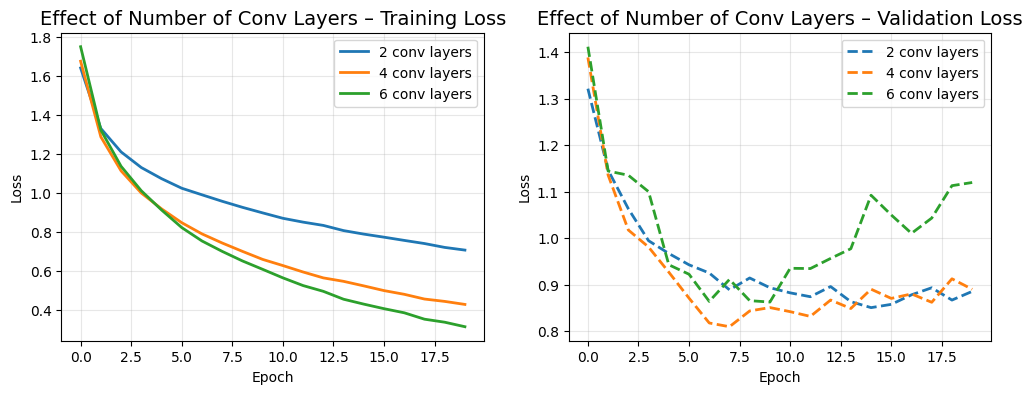

In [18]:
print("\n--- Loss Graphs (Number of Convolutional Layers) ---")
plot_history(MockHistory(histories_conv_layers), "Number of Conv Layers")

In [19]:
def create_model_varied_filters(filter_config, input_shape, num_classes, base_model_name="CNN"):
    model = models.Sequential(name=f"{base_model_name}_Filters_{'_'.join(map(str, filter_config))}")
    model.add(layers.Input(shape=input_shape))

    kernel_size = (3, 3)
    pool_size = (2, 2)

    for i, num_filters in enumerate(filter_config):
        model.add(layers.Conv2D(num_filters, kernel_size, activation='relu', padding='same', name=f"conv2d_layer_{i+1}"))
        model.add(layers.MaxPooling2D(pool_size, name=f"maxpool_layer_{i+1}"))

    model.add(layers.Flatten(name="flatten_layer"))
    model.add(layers.Dense(128, activation='relu', name="dense_layer_1"))
    model.add(layers.Dropout(0.5, name="dropout_layer"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output_layer"))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=METRICS_TO_COMPILE)
    return model

filter_variations = {
    "few_filters": [16, 32, 64],   
    "medium_filters": [32, 64, 128],
    "many_filters": [64, 128, 256]  
}

histories_num_filters = {}
f1_scores_num_filters = {}

print("\n--- Starting Experiment: Number of Filters per Layer ---")
for name, config in filter_variations.items():
    model_name = f"{name}_config"
    print(f"\nTraining model with filter configuration: {name} ({config})...")
    model = create_model_varied_filters(config, INPUT_SHAPE, NUM_CLASSES, base_model_name="3ConvLayer")
    model.summary()
    
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=1)
    
    histories_num_filters[model_name] = history.history
    f1 = evaluate_model_f1(model, X_test, y_test, model_name=model_name)
    f1_scores_num_filters[model_name] = f1

experiment_results['num_filters'] = {
    'f1_scores': f1_scores_num_filters,
    'histories': histories_num_filters
}


--- Starting Experiment: Number of Filters per Layer ---

Training model with filter configuration: few_filters ([16, 32, 64])...


Model: "3ConvLayer_Filters_16_32_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,074 (609.66 KB)

 Trainable params: 156,074 (609.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.2911 - f1_score_macro: 0.4563 - loss: 1.9038 - val_accuracy: 0.5139 - val_f1_score_macro: 0.5016 - val_loss: 1.3521
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4952 - f1_score_macro: 0.4872 - loss: 1.4001 - val_accuracy: 0.5634 - val_f1_score_macro: 0.5697 - val_loss: 1.2289
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5527 - f1_score_macro: 0.5482 - loss: 1.2361 - val_accuracy: 0.6230 - val_f1_score_macro: 0.6211 - val_loss: 1.0741
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6024 - f1_score_macro: 0.5994 - loss: 1.1227 - val_accuracy: 0.6421 - val_f1_score_macro: 0.6360 - val_loss: 1.0055
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6373 - f1_score_macro: 0.6345 - loss: 1.0288 - val_accuracy: 0.6541 - val_f1_score_macro: 0.6476 - val_loss: 0.9764
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6624 - f1_score_macro:

Model: "3ConvLayer_Filters_32_64_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.3116 - f1_score_macro: 0.4733 - loss: 1.8495 - val_accuracy: 0.5523 - val_f1_score_macro: 0.5434 - val_loss: 1.2426
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5255 - f1_score_macro: 0.5185 - loss: 1.3168 - val_accuracy: 0.6262 - val_f1_score_macro: 0.6264 - val_loss: 1.0459
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6072 - f1_score_macro: 0.6027 - loss: 1.1079 - val_accuracy: 0.6806 - val_f1_score_macro: 0.6824 - val_loss: 0.9074
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6575 - f1_score_macro: 0.6544 - loss: 0.9841 - val_accuracy: 0.7059 - val_f1_score_macro: 0.7050 - val_loss: 0.8434
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6931 - f1_score_macro: 0.6922 - loss: 0.8889 - val_accuracy: 0.7160 - val_f1_score_macro: 0.7202 - val_loss: 0.8165
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7125 - f1_score_macro:

Model: "3ConvLayer_Filters_64_128_256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,522 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.3134 - f1_score_macro: 0.4836 - loss: 1.8399 - val_accuracy: 0.5926 - val_f1_score_macro: 0.5839 - val_loss: 1.1411
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5671 - f1_score_macro: 0.5629 - loss: 1.2191 - val_accuracy: 0.6572 - val_f1_score_macro: 0.6581 - val_loss: 0.9783
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6439 - f1_score_macro: 0.6417 - loss: 1.0210 - val_accuracy: 0.7102 - val_f1_score_macro: 0.7083 - val_loss: 0.8443
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6981 - f1_score_macro: 0.6959 - loss: 0.8773 - val_accuracy: 0.7236 - val_f1_score_macro: 0.7209 - val_loss: 0.8055
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7323 - f1_score_macro: 0.7302 - loss: 0.7657 - val_accuracy: 0.7397 - val_f1_score_macro: 0.7409 - val_loss: 0.7469
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7648 - f1_score_m

In [20]:
print("\n--- F1-Scores (Number of Filters) ---")
for name, score in f1_scores_num_filters.items():
    print(f"{name}: {score:.4f}")


--- F1-Scores (Number of Filters) ---
few_filters_config: 0.7336
medium_filters_config: 0.7560
many_filters_config: 0.7710



--- Loss Graphs (Number of Filters) ---


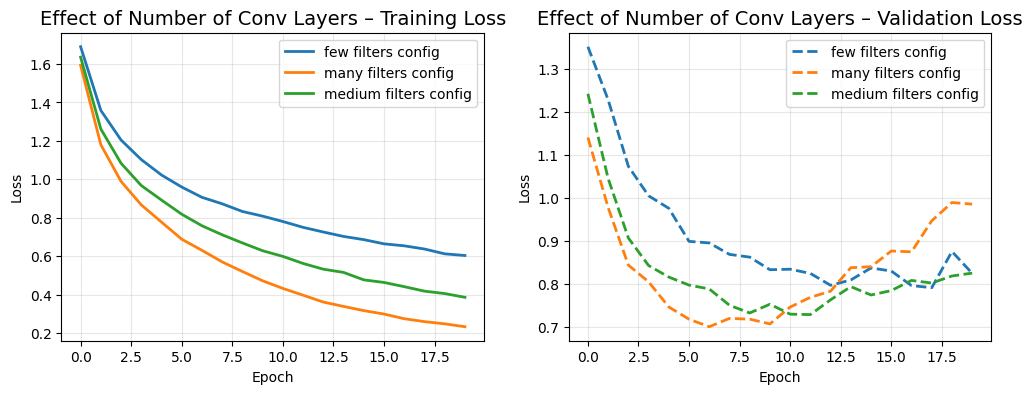

In [21]:
print("\n--- Loss Graphs (Number of Filters) ---")
plot_history(MockHistory(histories_num_filters), "Number of Conv Layers")

In [22]:
def create_model_varied_kernel_size(kernel_config, num_filters_per_layer, input_shape, num_classes, base_model_name="CNN"):
    model = models.Sequential(name=f"{base_model_name}_Kernel_{str(kernel_config).replace(', ','-').replace('(','').replace(')','')}")
    model.add(layers.Input(shape=input_shape))
    
    pool_size = (2, 2)
    
    is_list_of_kernels = isinstance(kernel_config, list)

    for i, num_filters in enumerate(num_filters_per_layer):
        kernel_size_to_use = kernel_config[i] if is_list_of_kernels else kernel_config
        model.add(layers.Conv2D(num_filters, kernel_size_to_use, activation='relu', padding='same', name=f"conv2d_layer_{i+1}"))
        model.add(layers.MaxPooling2D(pool_size, name=f"maxpool_layer_{i+1}"))

    model.add(layers.Flatten(name="flatten_layer"))
    model.add(layers.Dense(128, activation='relu', name="dense_layer_1"))
    model.add(layers.Dropout(0.5, name="dropout_layer"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output_layer"))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=METRICS_TO_COMPILE)
    return model

default_filters_for_kernel_exp = [32, 64, 128] 

kernel_size_variations = {
    "kernel_3x3": (3,3),
    "kernel_5x5": (5,5),
    "kernel_7x7": (7,7) 
}

histories_kernel_size = {}
f1_scores_kernel_size = {}

print("\n--- Starting Experiment: Filter Size (Kernel Size) ---")
for name, kernel_conf in kernel_size_variations.items():
    model_name = f"{name}_config"
    print(f"\nTraining model with kernel configuration: {name} ({kernel_conf})...")
    model = create_model_varied_kernel_size(kernel_conf, default_filters_for_kernel_exp, INPUT_SHAPE, NUM_CLASSES, base_model_name="3ConvLayer")
    model.summary()

    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=1)
    
    histories_kernel_size[model_name] = history.history
    f1 = evaluate_model_f1(model, X_test, y_test, model_name=model_name)
    f1_scores_kernel_size[model_name] = f1

experiment_results['kernel_size'] = {
    'f1_scores': f1_scores_kernel_size,
    'histories': histories_kernel_size
}


--- Starting Experiment: Filter Size (Kernel Size) ---

Training model with kernel configuration: kernel_3x3 ((3, 3))...


Model: "3ConvLayer_Kernel_3-3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.2964 - f1_score_macro: 0.4780 - loss: 1.8931 - val_accuracy: 0.5456 - val_f1_score_macro: 0.5447 - val_loss: 1.2847
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5179 - f1_score_macro: 0.5126 - loss: 1.3384 - val_accuracy: 0.6178 - val_f1_score_macro: 0.6141 - val_loss: 1.0674
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6027 - f1_score_macro: 0.6003 - loss: 1.1282 - val_accuracy: 0.6687 - val_f1_score_macro: 0.6692 - val_loss: 0.9450
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6483 - f1_score_macro: 0.6468 - loss: 1.0072 - val_accuracy: 0.6908 - val_f1_score_macro: 0.6921 - val_loss: 0.8811
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6814 - f1_score_macro: 0.6793 - loss: 0.9097 - val_accuracy: 0.7053 - val_f1_score_macro: 0.7071 - val_loss: 0.8408
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7076 - f1_score_macro:

Model: "3ConvLayer_Kernel_5-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,186 (1.99 MB)

 Trainable params: 522,186 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.2955 - f1_score_macro: 0.4704 - loss: 1.9010 - val_accuracy: 0.5176 - val_f1_score_macro: 0.5183 - val_loss: 1.3253
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5345 - f1_score_macro: 0.5292 - loss: 1.3033 - val_accuracy: 0.6166 - val_f1_score_macro: 0.6114 - val_loss: 1.0874
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6166 - f1_score_macro: 0.6145 - loss: 1.0921 - val_accuracy: 0.6583 - val_f1_score_macro: 0.6548 - val_loss: 0.9723
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6768 - f1_score_macro: 0.6746 - loss: 0.9293 - val_accuracy: 0.6815 - val_f1_score_macro: 0.6807 - val_loss: 0.9196
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7174 - f1_score_macro: 0.7156 - loss: 0.8121 - val_accuracy: 0.7091 - val_f1_score_macro: 0.7107 - val_loss: 0.8393
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7436 - f1_score_

Model: "3ConvLayer_Kernel_7-7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,250 (2.94 MB)

 Trainable params: 770,250 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - accuracy: 0.2859 - f1_score_macro: 0.4544 - loss: 1.9161 - val_accuracy: 0.5049 - val_f1_score_macro: 0.4980 - val_loss: 1.3698
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5133 - f1_score_macro: 0.5091 - loss: 1.3713 - val_accuracy: 0.5682 - val_f1_score_macro: 0.5568 - val_loss: 1.2267
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5868 - f1_score_macro: 0.5839 - loss: 1.1816 - val_accuracy: 0.6242 - val_f1_score_macro: 0.6196 - val_loss: 1.0686
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6399 - f1_score_macro: 0.6384 - loss: 1.0325 - val_accuracy: 0.6376 - val_f1_score_macro: 0.6383 - val_loss: 1.0493
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6829 - f1_score_macro: 0.6822 - loss: 0.9181 - val_accuracy: 0.6704 - val_f1_score_macro: 0.6751 - val_loss: 0.9737
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7193 - f1_sc

In [23]:
print("\n--- F1-Scores (Filter Size) ---")
for name, score in f1_scores_kernel_size.items():
    print(f"{name}: {score:.4f}")


--- F1-Scores (Filter Size) ---
kernel_3x3_config: 0.7531
kernel_5x5_config: 0.7256
kernel_7x7_config: 0.6796



--- Loss Graphs (Filter Size) ---


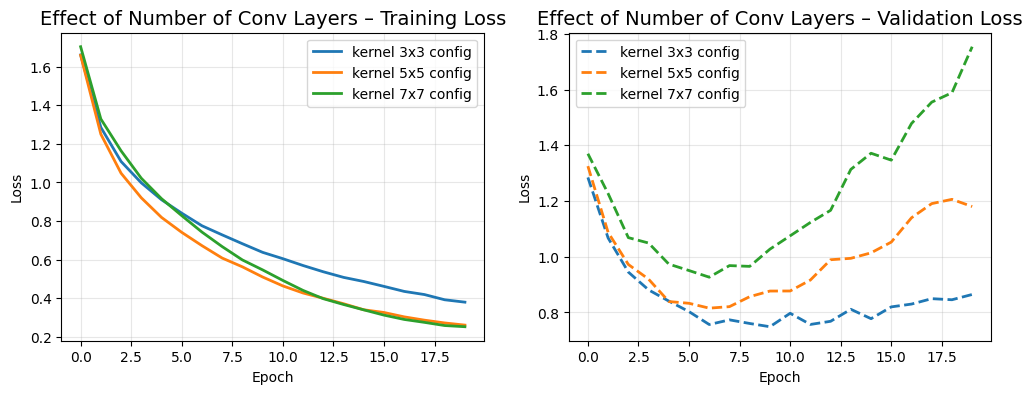

In [24]:
print("\n--- Loss Graphs (Filter Size) ---")
plot_history(MockHistory(histories_kernel_size), "Number of Conv Layers")

In [25]:
def create_model_varied_pooling(pooling_type, input_shape, num_classes, base_model_name="CNN_Pooling"):
    model = models.Sequential(name=f"{base_model_name}_{pooling_type.capitalize()}Pool")
    model.add(layers.Input(shape=input_shape))

    filters_config = [32, 64, 128]
    kernel_size = (3,3)
    pool_size = (2,2)

    for i, num_filters in enumerate(filters_config):
        model.add(layers.Conv2D(num_filters, kernel_size, activation='relu', padding='same', name=f"conv2d_layer_{i+1}"))
        if pooling_type == 'max':
            model.add(layers.MaxPooling2D(pool_size, name=f"maxpool_layer_{i+1}"))
        elif pooling_type == 'average':
            model.add(layers.AveragePooling2D(pool_size, name=f"avgpool_layer_{i+1}"))
        else:
            raise ValueError("Unknown pooling type. Choose 'max' or 'average'.")

    model.add(layers.Flatten(name="flatten_layer"))
    model.add(layers.Dense(128, activation='relu', name="dense_layer_1"))
    model.add(layers.Dropout(0.5, name="dropout_layer"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output_layer"))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=METRICS_TO_COMPILE)
    return model

pooling_variations = ["max", "average"]
histories_pooling_type = {}
f1_scores_pooling_type = {}

print("\n--- Starting Experiment: Type of Pooling Layer ---")
for pool_name in pooling_variations:
    model_name = f"{pool_name}_pooling"
    print(f"\nTraining model with {pool_name} pooling...")
    model = create_model_varied_pooling(pool_name, INPUT_SHAPE, NUM_CLASSES)
    model.summary()
    
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=1)
    
    histories_pooling_type[model_name] = history.history
    f1 = evaluate_model_f1(model, X_test, y_test, model_name=model_name)
    f1_scores_pooling_type[model_name] = f1

experiment_results['pooling_type'] = {
    'f1_scores': f1_scores_pooling_type,
    'histories': histories_pooling_type
}


--- Starting Experiment: Type of Pooling Layer ---

Training model with max pooling...


Model: "CNN_Pooling_MaxPool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.2958 - f1_score_macro: 0.4407 - loss: 1.9016 - val_accuracy: 0.5474 - val_f1_score_macro: 0.5291 - val_loss: 1.2647
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5168 - f1_score_macro: 0.5108 - loss: 1.3385 - val_accuracy: 0.5917 - val_f1_score_macro: 0.5943 - val_loss: 1.1271
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6004 - f1_score_macro: 0.5976 - loss: 1.1308 - val_accuracy: 0.6643 - val_f1_score_macro: 0.6591 - val_loss: 0.9632
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6474 - f1_score_macro: 0.6455 - loss: 1.0089 - val_accuracy: 0.6737 - val_f1_score_macro: 0.6708 - val_loss: 0.9234
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6796 - f1_score_macro: 0.6781 - loss: 0.9082 - val_accuracy: 0.7208 - val_f1_score_macro: 0.7204 - val_loss: 0.8127
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7137 - f1_score_macro:

Model: "CNN_Pooling_AveragePool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_layer_1                 │ (None, 16, 16, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_layer_2                 │ (None, 8, 8, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_layer_3                 │ (None, 4, 4, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.2925 - f1_score_macro: 0.4665 - loss: 1.9035 - val_accuracy: 0.5075 - val_f1_score_macro: 0.4962 - val_loss: 1.3606
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4923 - f1_score_macro: 0.4855 - loss: 1.4173 - val_accuracy: 0.5483 - val_f1_score_macro: 0.5421 - val_loss: 1.2400
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5542 - f1_score_macro: 0.5503 - loss: 1.2481 - val_accuracy: 0.6267 - val_f1_score_macro: 0.6215 - val_loss: 1.0567
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5941 - f1_score_macro: 0.5921 - loss: 1.1369 - val_accuracy: 0.6488 - val_f1_score_macro: 0.6409 - val_loss: 0.9979
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6314 - f1_score_macro: 0.6283 - loss: 1.0437 - val_accuracy: 0.6751 - val_f1_score_macro: 0.6692 - val_loss: 0.9224
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6605 - f1_score_macro:

In [26]:
print("\n--- F1-Scores (Pooling Type) ---")
for name, score in f1_scores_pooling_type.items():
    print(f"{name.replace('_', ' ').capitalize()}: {score:.4f}")


--- F1-Scores (Pooling Type) ---
Max pooling: 0.7494
Average pooling: 0.7681



--- Loss Graphs (Pooling Type) ---


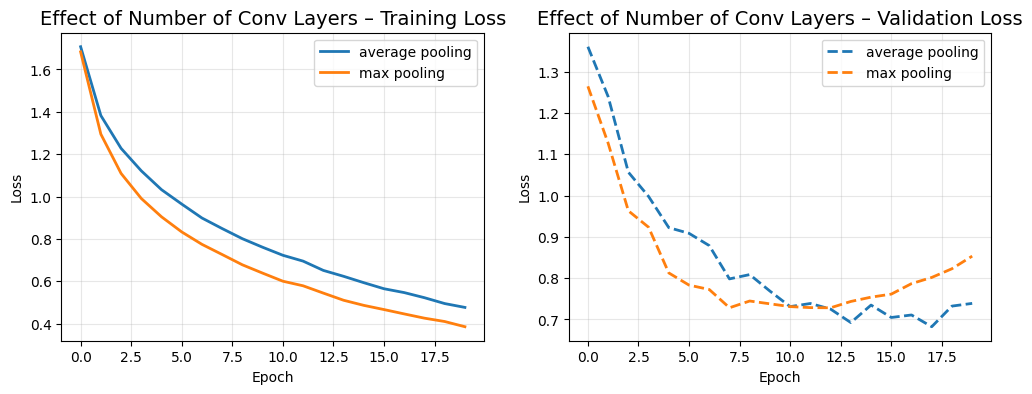

: 

In [ ]:
print("\n--- Loss Graphs (Pooling Type) ---")
plot_history(MockHistory(histories_pooling_type), "Number of Conv Layers")